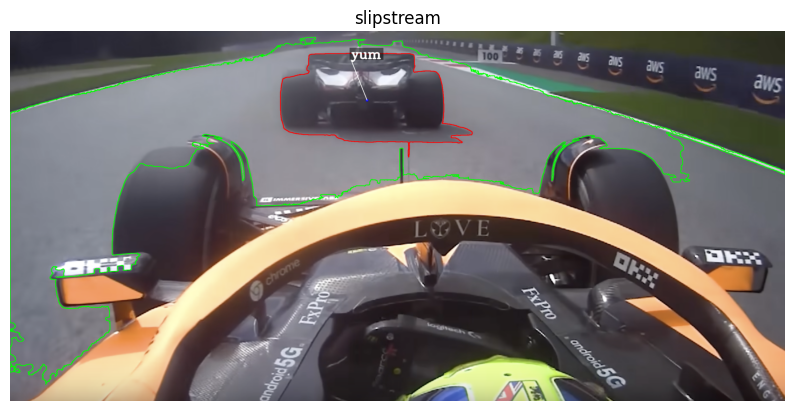

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def contour_inside_another(contour, container_contour, threshold=0.8):
    inside_count = 0
    for pt in contour:
        pt_tuple = (float(pt[0][0]), float(pt[0][1]))
        if cv2.pointPolygonTest(container_contour, pt_tuple, False) >= 0:
            inside_count += 1
    return inside_count / len(contour) >= threshold

# load img
image_path = 'rear.png'
img = cv2.imread(image_path)
hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

# masks
car_mask = cv2.inRange(hsv_img, (98,0,18), (180,98,134))
track_mask = cv2.inRange(hsv_img, (104, 0, 125), (162, 42, 255))

# top mask, top 40% of image only
height, width = car_mask.shape
top_only_mask = np.zeros_like(car_mask)
top_cutoff = int(height * 1.0)  # 0.4
top_only_mask[:top_cutoff, :] = 255
# apply
car_mask = cv2.bitwise_and(car_mask, top_only_mask)
track_mask = cv2.bitwise_and(track_mask, top_only_mask)

# get largest track contour
track_contours, _ = cv2.findContours(track_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
track_contour = max(track_contours, key=cv2.contourArea)

# find car contours
car_contours, _ = cv2.findContours(car_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# get only the contours inside the track contour
min_area = 100000
filtered_car_contours = []

for c in car_contours:
    area = cv2.contourArea(c)
    if area < min_area:
        continue
    if contour_inside_another(c, track_contour, threshold=1.0):
        filtered_car_contours.append(c)

# draw results
output_img = img.copy()
label = "yum"
font = cv2.FONT_HERSHEY_COMPLEX
font_scale = 1.5
font_thickness = 3


cv2.drawContours(output_img, [track_contour], -1, (0, 255, 0), 2)  # track contour
for c in filtered_car_contours:
    # Draw contour
    cv2.drawContours(output_img, [c], -1, (0, 0, 255), 2)
    
    M = cv2.moments(c)
    if M['m00'] != 0:
        cx = int(M['m10'] / M['m00'])
        cy = int(M['m01'] / M['m00'])
        cv2.circle(output_img, (cx, cy), 5, (255, 0, 0), -1)

        # 1. Find the topmost point of the contour
        topmost = tuple(c[c[:,:,1].argmin()][0])
        tag_x, tag_y = topmost

        # 2. Prepare text size and position
        text_size, _ = cv2.getTextSize(label, font, font_scale, font_thickness)
        text_w, text_h = text_size
        text_x = tag_x  # - text_w // 2
        text_y = tag_y - -20  # 20 pixels below the topmost point

        # 3. Draw semi-transparent rectangle as background
        overlay = output_img.copy()
        rect_pt1 = (text_x - 5, text_y - text_h - 5)
        rect_pt2 = (text_x + text_w + 5, text_y + 5)
        cv2.rectangle(overlay, rect_pt1, rect_pt2, (0, 0, 0), -1)
        alpha = 0.5
        output_img = cv2.addWeighted(overlay, alpha, output_img, 1 - alpha, 0)

        # 4. Draw the text
        cv2.putText(
            output_img, label, (text_x, text_y),
            font, font_scale, (255, 255, 255), font_thickness, cv2.LINE_AA
        )

        # 5. Draw a line from the name tag to the object center
        line_start = (tag_x, text_y + 5)
        line_end = (cx, cy)
        cv2.line(output_img, line_start, line_end, (255, 255, 255), 2)

plt.figure(figsize=(10,6))
plt.imshow(cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB))
plt.title("slipstream")
plt.axis('off')
plt.show()